In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.ndimage import binary_erosion, distance_transform_edt

import numpy as np
from scipy.ndimage import binary_erosion, distance_transform_edt


def generate_coastal_mask(veg_type: np.ndarray, buffer_km: float = 50.0, grid_spacing_km: float = 3.0) -> np.ndarray:
    """
    Returns a new landmask where any point within `buffer_km` of the coastline is set to 0 (masked).

    Args:
        veg_type: 2D array with 44 for water.
        buffer_km: Distance from coastline to mask, in km.
        grid_spacing_km: Grid spacing in km (e.g., 3 for WRF 1km grid).

    Returns:
        new_landmask: same shape as input, with coastal zone masked out.
    """
    # Create landmask: 1 for land, 0 for water
    landmask = np.ones_like(veg_type, dtype=np.uint8)
    landmask[veg_type == 44] = 0
    land_binary = landmask.astype(bool)
    eroded_land = binary_erosion(land_binary)
    coastline = land_binary & (~eroded_land)

    # Compute distance (in grid cells) from coastline
    distance = distance_transform_edt(~coastline) * grid_spacing_km

    # Mask everything within `buffer_km` from coastline
    new_landmask = landmask.copy()
    new_landmask[distance <= buffer_km] = 0

    return new_landmask

def proj_on_finer_WRF_grid(
    lats_coarse, lons_coarse, var_coarse, lats_fine, lons_fine, WRF_var_1km,method_in
):
    proj_var = griddata(
        (lats_coarse.flatten(), lons_coarse.flatten()),
        var_coarse.flatten(),
        (lats_fine, lons_fine),
        method=method_in,
    ).reshape(WRF_var_1km.shape)
    return proj_var

def proj_on_finer_WRF_grid_3D(
    lats_coarse: np.ndarray,
    lons_coarse: np.ndarray,
    var_coarse: np.ndarray,
    lats_fine: np.ndarray,
    lons_fine: np.ndarray,
    WRF_var_1km: np.ndarray,
    method_in: str,
) -> np.ndarray:
    """
    Interpolates 3D WRF data (z, y, x) from coarse grid to finer 1km WRF grid using cubic interpolation.
    """
    z_levels = var_coarse.shape[0]
    interp_shape = WRF_var_1km.shape
    proj_var = np.empty(interp_shape, dtype=np.float32)

    for z in range(z_levels):
        proj_var[z] = griddata(
            (lats_coarse.flatten(), lons_coarse.flatten()),
            var_coarse[z].flatten(),
            (lats_fine, lons_fine),
            method=method_in,
        ).reshape(interp_shape[1:])  # (y_fine, x_fine)

    return proj_var

############# INPUT ############
plots_folder = "/home/c707/c7071034/Github/WRF_VPRM_post/plots/test_"
save_plot = True
dx = "_54km" 
interp_method = "nearest"  # 'linear', 'nearest', 'cubic'
temp_gradient = -6.5 # K/km
STD_TOPO = 200
dateime = "2012-07-27_12"
subfolder = "" # "" or "_cloudy" TODO _rainy
wrfinput_path_1km = f"/scratch/c7071034/DATA/WRFOUT/WRFOUT_ALPS_1km{subfolder}/wrfout_d02_{dateime}:00:00"
wrfinput_path_54km = f"/scratch/c7071034/DATA/WRFOUT/WRFOUT_ALPS{dx}{subfolder}/wrfout_d01_{dateime}:00:00"
################################

# Load the NetCDF file
nc_fid1km = nc.Dataset(wrfinput_path_1km, "r")
nc_fid54km = nc.Dataset(wrfinput_path_54km, "r")
dGPPdT = -nc_fid54km.variables['EBIO_GEE_DPDT'][:]
dGPPdT_1km = -nc_fid1km.variables['EBIO_GEE_DPDT'][0,0, 10:-10, 10:-10]
GPP_1km = -nc_fid1km.variables['EBIO_GEE'][0,0,10:-10, 10:-10]
GPP_54km = -nc_fid54km.variables['EBIO_GEE'][0,0, :,:]

dRECOdT = nc_fid54km.variables['EBIO_RES_DPDT'][:]
dRECOdT_1km = nc_fid1km.variables['EBIO_RES_DPDT'][0,0,10:-10, 10:-10]
HGT_1km = nc_fid1km.variables['HGT'][0,10:-10, 10:-10]
HGT_54km = nc_fid54km.variables['HGT'][0]
T2_1km = nc_fid1km.variables['T2'][0,10:-10, 10:-10]-273.15
T2_54km = nc_fid54km.variables['T2'][0]-273.15
lats_fine = nc_fid1km.variables["XLAT"][0, 10:-10, 10:-10]
lons_fine = nc_fid1km.variables["XLONG"][0, 10:-10, 10:-10]
# landmask = nc_fid1km.variables["LANDMASK"][0, :, :]
veg_type = nc_fid54km.variables["IVGTYP"][0, :, :]
stdh_topo_1km = nc_fid1km.variables["VAR"][0, 10:-10, 10:-10]
stdh_mask = stdh_topo_1km >= STD_TOPO

lats_54km = nc_fid54km.variables["XLAT"][0, :, :]
lons_54km = nc_fid54km.variables["XLONG"][0, :, :]
CLDFRC_1km = nc_fid1km.variables["CLDFRA"][0, :, 10:-10, 10:-10] 
CLDFRC_54km = nc_fid54km.variables["CLDFRA"][0, :, :, :]


#GPP_54km
proj_GPP_54km = proj_on_finer_WRF_grid(
    lats_54km,
    lons_54km,
    GPP_54km,
    lats_fine,
    lons_fine,
    GPP_1km,
    interp_method,
)
new_landmask = generate_coastal_mask(veg_type, buffer_km=30.0, grid_spacing_km=50.0)


proj_landmask_54km = proj_on_finer_WRF_grid(
    lats_54km,
    lons_54km,
    new_landmask,
    lats_fine,
    lons_fine,
    HGT_1km,
    interp_method,
)
proj_HGT_54km = proj_on_finer_WRF_grid(
    lats_54km,
    lons_54km,
    HGT_54km,
    lats_fine,
    lons_fine,
    HGT_1km,
    interp_method,
)
proj_T2_54km = proj_on_finer_WRF_grid(
    lats_54km,
    lons_54km,
    T2_54km,
    lats_fine,
    lons_fine,
    T2_1km,
    interp_method,
)
proj_dGPPdT_54km = proj_on_finer_WRF_grid(
    lats_54km,
    lons_54km,
    dGPPdT,
    lats_fine,
    lons_fine,
    HGT_1km,
    interp_method,
)
proj_CLDFRC_54km = proj_on_finer_WRF_grid_3D(
    lats_54km,
    lons_54km,
    CLDFRC_54km,
    lats_fine,
    lons_fine,
    CLDFRC_1km,
    interp_method,
)
#dRECOdT
proj_dRECOdT_54km = proj_on_finer_WRF_grid(
    lats_54km,
    lons_54km,
    dRECOdT,
    lats_fine,
    lons_fine,
    dRECOdT_1km,
    interp_method,
)

diff_HGT =  proj_HGT_54km - HGT_1km
diff_HGT[proj_landmask_54km*stdh_mask == 0] = np.nan
conv_factor = 1/3600

dGPPdT_1km[T2_1km < 0] = np.nan
mask_0to5 = (T2_1km >= 0) & (T2_1km <= 5)
val_at5C = 1
dGPPdT_1km[mask_0to5] = val_at5C

dT_calc = diff_HGT/1000*temp_gradient
dT_model = proj_T2_54km - T2_1km # TODO why converting sign? 
dGPP_calc = dGPPdT_1km * conv_factor * dT_calc 
dGPP_model = dGPPdT_1km * conv_factor * dT_model
dGPP_real = (proj_GPP_54km - GPP_1km)* conv_factor
dRECO_model = dRECOdT_1km * conv_factor * dT_model
# Avoid division by very small values by masking or thresholding dT_model
dT_threshold = 1.3  # K, or set to a value appropriate for your data
safe_dT_model = np.where(np.abs(dT_model) > dT_threshold, dT_model, np.nan)
dGPPdT_real = dGPP_real / safe_dT_model

dT_calc[proj_landmask_54km*stdh_mask == 0] = np.nan
dT_model[proj_landmask_54km*stdh_mask == 0] = np.nan
dGPP_calc[proj_landmask_54km*stdh_mask == 0] = np.nan
dGPP_model[proj_landmask_54km*stdh_mask == 0] = np.nan
dGPPdT_real[proj_landmask_54km*stdh_mask == 0] = np.nan
CLDFRC_1km_max = np.nanmax(CLDFRC_1km, axis=0)   
CLDFRC_54km_max = np.nanmax(proj_CLDFRC_54km, axis=0)

def styled_imshow_plot(data, vmin, vmax, cmap, label, filename):
    fig, ax = plt.subplots(figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})
    
    im = ax.imshow(
        data,
        extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
        cmap=cmap,
        origin='lower',
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax
    )
    
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.3, fraction=0.046, pad=0.06)
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(label, fontsize=20)
    
    gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='black', alpha=0.2, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}
    
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAKES, linewidth=0.5)
    ax.add_feature(cfeature.RIVERS, linewidth=0.5)
    
    plt.tight_layout()
    if save_plot:
        plt.savefig(f"{plots_folder}{filename}_{dateime}h.pdf", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

#CLDFRC_max
styled_imshow_plot(CLDFRC_1km_max, 0, 1, 'Blues', 'cloud fraction [%]', 'CLDFRC_1km')
styled_imshow_plot(CLDFRC_54km_max, 0, 1, 'Blues', 'cloud fraction [%]', 'CLDFRC_54km')

# Temperature
styled_imshow_plot(T2_1km, 0, 35, 'coolwarm_r', '2m Temperature (°C)', 'T2_1km')
styled_imshow_plot(proj_T2_54km, 0, 35, 'coolwarm_r', '2m Temperature (°C)', 'T2_54km')


# GPP 1km
styled_imshow_plot(GPP_1km * conv_factor, 0, 30, 'PiYG', 'GPP (μmol/m²/s)', 'GPP_1km')

# GPP 54km (reprojected)
styled_imshow_plot(proj_GPP_54km * conv_factor, 0, 30, 'PiYG', 'GPP (μmol/m²/s)', 'GPP_54')

# GPP model diff (54km - 1km)
styled_imshow_plot(dGPP_real, -15, 15, 'PiYG', 'ΔGPP (μmol/m²/s)', 'GPP_54-1km')

# GPP calc again (duplicated in earlier batch, but now renamed to not overwrite)
styled_imshow_plot(dGPP_calc, -15, 15, 'PiYG', 'ΔGPP (μmol/m²/s)', 'dGPP_model_02')

# dGPP/dT sensitivity
styled_imshow_plot(dGPPdT_1km * conv_factor, -2, 2, 'PiYG', 'dGPP/dT (μmol/m²/s/K)', 'dGPPdT_1km')
styled_imshow_plot(proj_dGPPdT_54km * conv_factor, -2, 2, 'PiYG', 'dGPP/dT (μmol/m²/s/K)', 'dGPPdT_54km')

# Temperature differences
styled_imshow_plot(dT_calc, -15, 15, 'coolwarm_r', 'ΔT (K)', 'dT_calc')
styled_imshow_plot(dT_model, -15, 15, 'coolwarm_r', 'ΔT (K)', 'dT_model')
styled_imshow_plot(dT_model - dT_calc, -15, 15, 'coolwarm_r', 'ΔT (K)', 'dT_model-calc')

# GPP differences
styled_imshow_plot(dGPP_calc, -15, 15, 'PiYG', 'ΔGPP (μmol/m²/s)', 'dGPP_calc')
styled_imshow_plot(dGPP_model, -15, 15, 'PiYG', 'ΔGPP (μmol/m²/s)', 'dGPP_model')
styled_imshow_plot(dGPP_model - dGPP_calc, -15, 15, 'PiYG', 'ΔGPP (μmol/m²/s)', 'dGPP_model-calc')

# RECO difference
styled_imshow_plot(dRECO_model, -15, 15, 'PiYG', 'ΔRECO (μmol/m²/s)', 'dRECO_model')




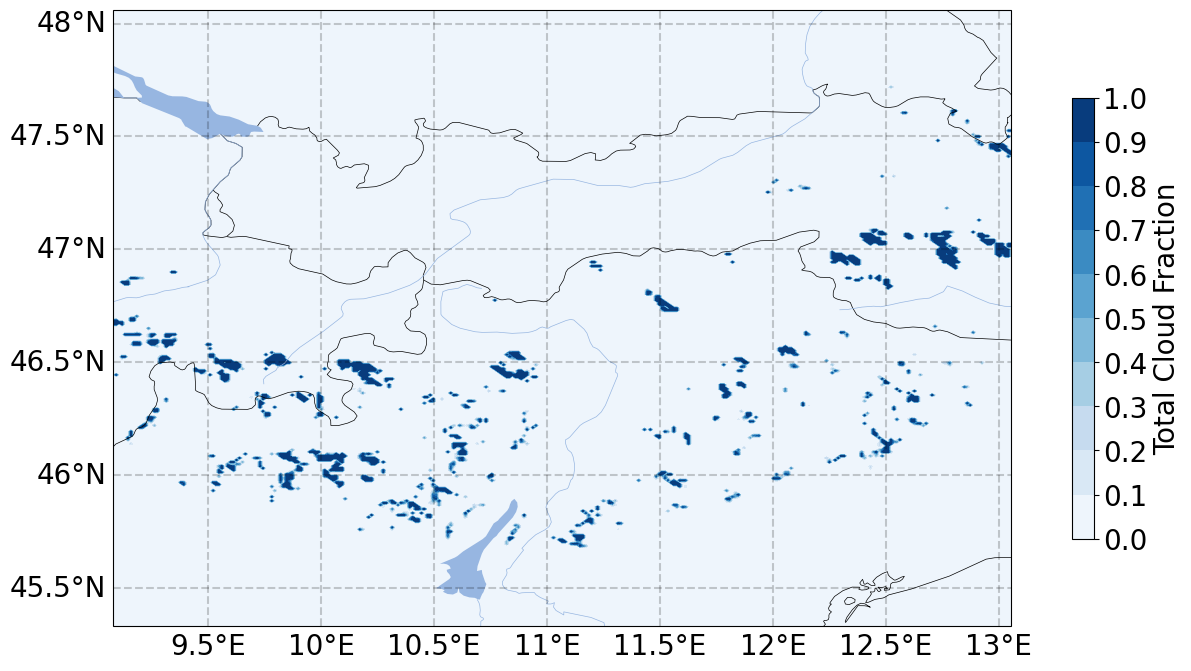

In [2]:
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Filled contour plot for cloud fraction
contour = ax.contourf(
    lons_fine, lats_fine, CLDFRC_1km_max,
    levels=np.linspace(0, 1, 11),
    cmap='Blues',
    transform=ccrs.PlateCarree()
)

# Colorbar styled like vegetation plot
cbar = fig.colorbar(
    contour,
    ax=ax,
    orientation='vertical',
    ticks=np.linspace(0, 1, 11),
    fraction=0.046,
    pad=0.06,
    shrink=0.3
)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Total Cloud Fraction', fontsize=20)

# Gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='black', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Cartopy features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)

plt.tight_layout()
plt.savefig(f"{plots_folder}CLDFR_1km_{dateime}h.pdf", bbox_inches='tight')
plt.show()


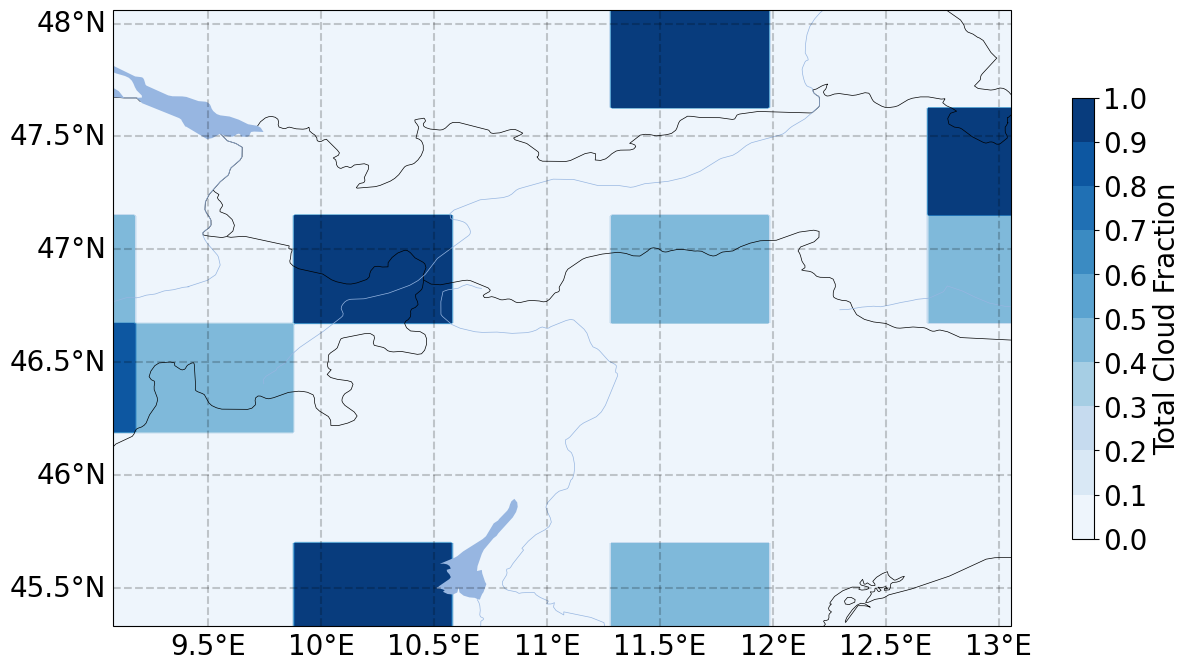

In [3]:
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Filled contour plot for cloud fraction
contour = ax.contourf(
    lons_fine, lats_fine, CLDFRC_54km_max,
    levels=np.linspace(0, 1, 11),
    cmap='Blues',
    transform=ccrs.PlateCarree()
)

# Colorbar styled like vegetation plot
cbar = fig.colorbar(
    contour,
    ax=ax,
    orientation='vertical',
    ticks=np.linspace(0, 1, 11),
    fraction=0.046,
    pad=0.06,
    shrink=0.3
)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Total Cloud Fraction', fontsize=20)

# Gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='black', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Cartopy features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)

plt.tight_layout()
plt.savefig(f"{plots_folder}CLDFR_1km_{dateime}h.pdf", bbox_inches='tight')
plt.show()


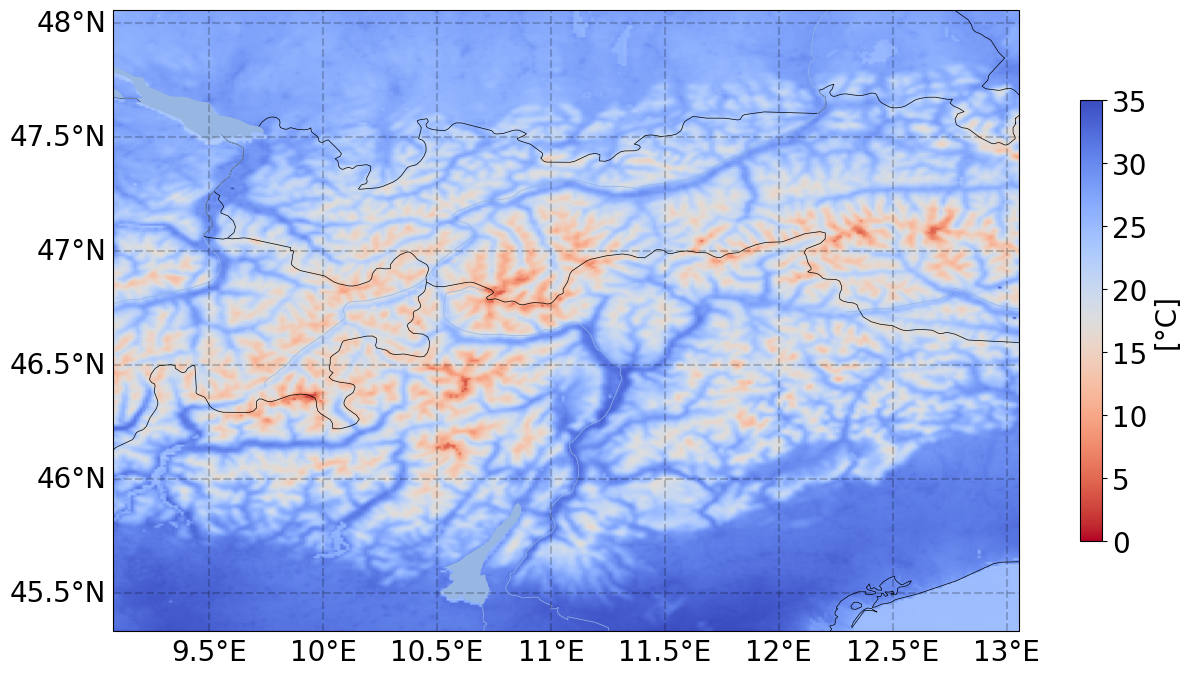

In [4]:
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})

# Image plot for temperature
im = ax.imshow(
    T2_1km,
    extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
    cmap='coolwarm_r',
    origin='lower',
    transform=ccrs.PlateCarree(),
    vmin=0, vmax=35
)

# Colorbar styled like cloud plot
cbar = plt.colorbar(
    im, ax=ax,
    orientation='vertical',
    shrink=0.3,
    fraction=0.046,
    pad=0.06
)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('[°C]', fontsize=20)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='black', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Labels
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)

# Cartopy features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)

plt.tight_layout()
plt.savefig(f"{plots_folder}T2_1km_{dateime}h.pdf", bbox_inches='tight')
plt.show()


In [5]:


# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(proj_T2_54km, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                cmap='coolwarm_r', origin='lower', transform=ccrs.PlateCarree(), vmin=0, vmax=35)
# # ax.set_title(f'T2 of 54 km {dateime}h \n mean(T2) = {np.nanmean(proj_T2_54km):.2f} °C')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}T2_54km_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # Plot and save dGPPdT
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dGPPdT_1km * conv_factor, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
# # ax.set_title(f'dGPPdT from WRF {dateime}h \n mean(dGPPdT) = {np.nanmean(dGPPdT_1km * conv_factor):.2f} μmol/m²/s/K')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s/K', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dGPPdT_1km_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # Plot and save dGPPdT
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(proj_dGPPdT_54km * conv_factor, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=-2, vmax=2)
# # ax.set_title(f'dGPPdT from WRF {dateime}h \n mean(dGPPdT) = {np.nanmean(proj_dGPPdT_54km * conv_factor):.2f} μmol/m²/s/K')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s/K', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dGPPdT_54km_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()


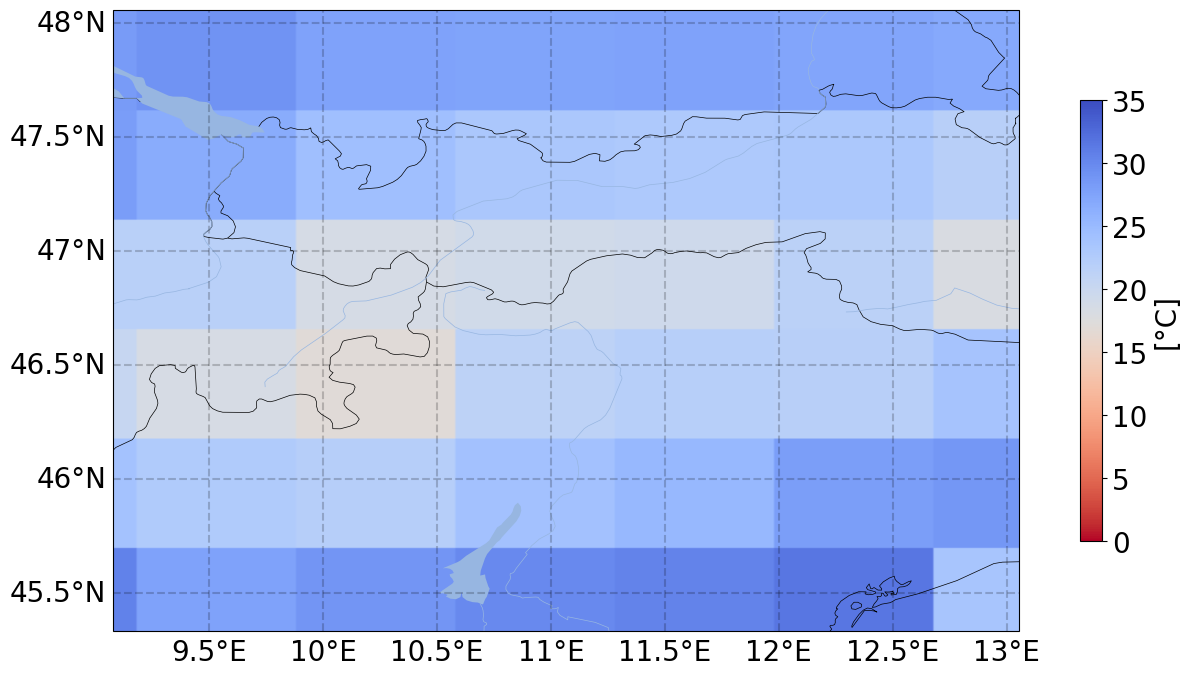

In [6]:
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.imshow(
    proj_T2_54km,
    extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
    cmap='coolwarm_r',
    origin='lower',
    transform=ccrs.PlateCarree(),
    vmin=0, vmax=35
)

cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.3, fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('[°C]', fontsize=20)

gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='black', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)

plt.tight_layout()
plt.savefig(f"{plots_folder}T2_54km_{dateime}h.pdf", bbox_inches='tight') if save_plot else plt.show()


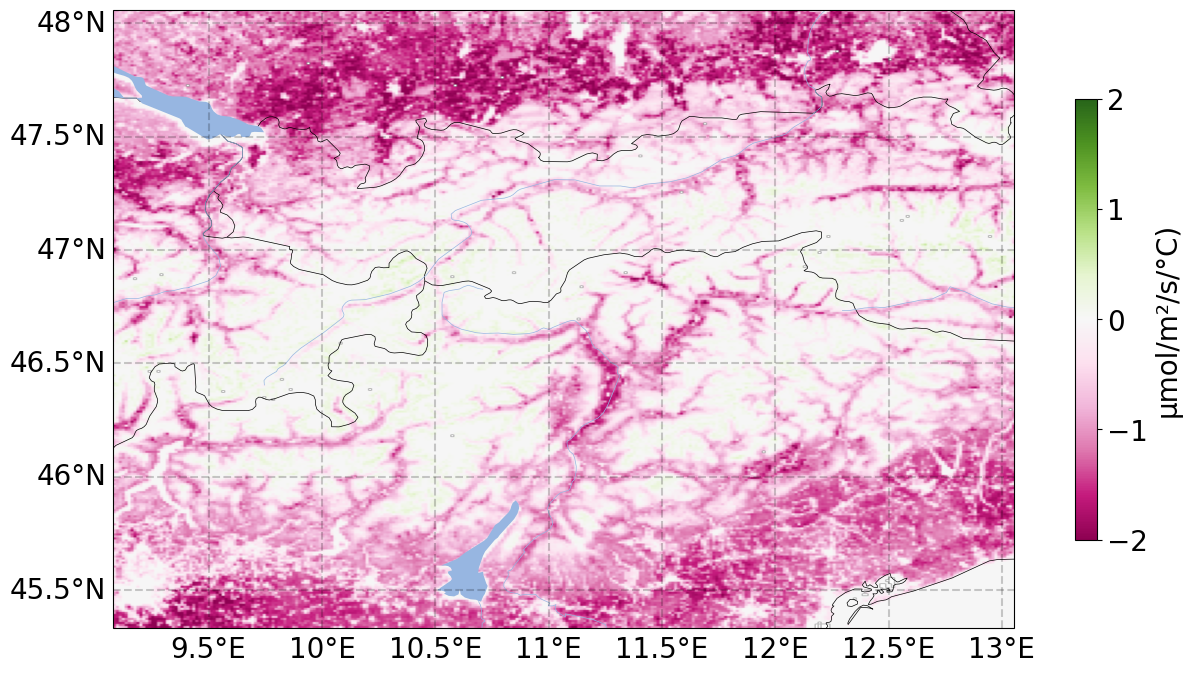

In [7]:
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.imshow(
    dGPPdT_1km * conv_factor,
    extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
    cmap='PiYG',
    origin='lower',
    transform=ccrs.PlateCarree(),
    vmin=-2, vmax=2
)

cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.3, fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('μmol/m²/s/°C)', fontsize=20)

gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='black', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)

plt.tight_layout()
plt.savefig(f"{plots_folder}dGPPdT_1km_{dateime}h.pdf", bbox_inches='tight') if save_plot else plt.show()


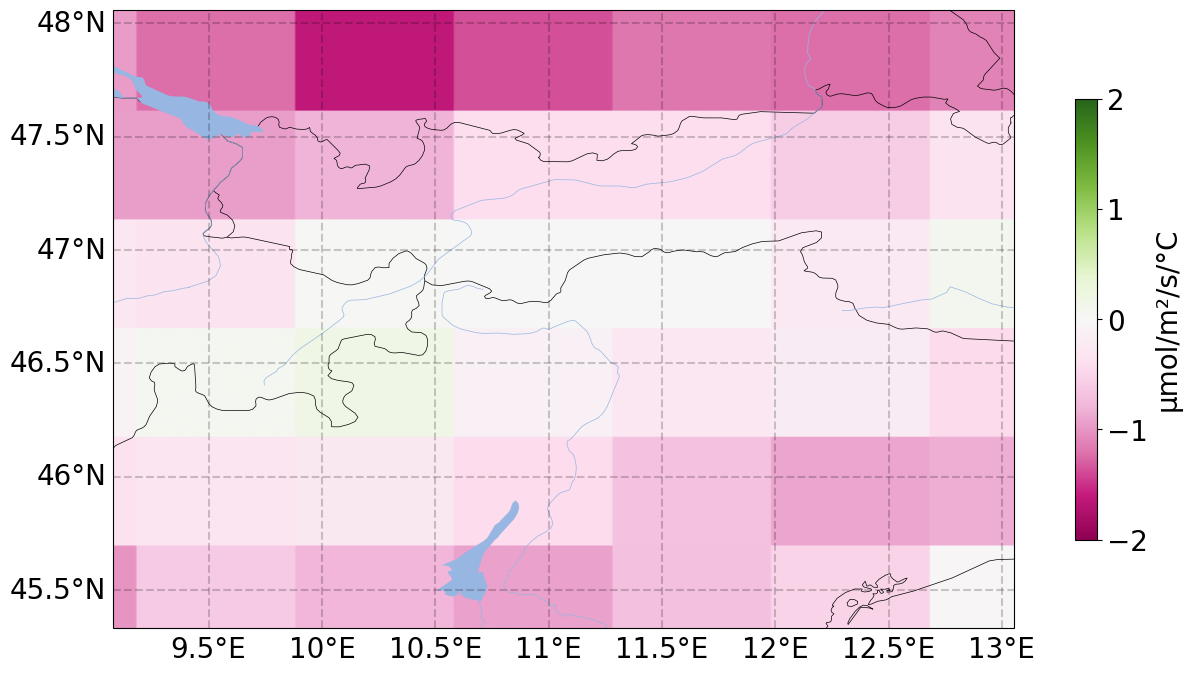

In [8]:
fig, ax = plt.subplots(figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})
im = ax.imshow(
    proj_dGPPdT_54km * conv_factor,
    extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
    cmap='PiYG',
    origin='lower',
    transform=ccrs.PlateCarree(),
    vmin=-2, vmax=2
)

cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.3, fraction=0.046, pad=0.06)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('μmol/m²/s/°C', fontsize=20)

gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='black', alpha=0.2, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAKES, linewidth=0.5)
ax.add_feature(cfeature.RIVERS, linewidth=0.5)

plt.tight_layout()
plt.savefig(f"{plots_folder}dGPPdT_54km_{dateime}h.pdf", bbox_inches='tight') if save_plot else plt.show()


In [9]:

# # 
# # Plot and save dT_calc
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dT_calc, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='coolwarm_r', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'Temperature Difference from lapse rate * HGT(dx54km-dx1km) {dateime}h \n mean(dT_calc) = {np.nanmean(dT_calc):.2f} °C')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# # Make colorbar smaller by setting shrink parameter
# plt.colorbar(im, ax=ax, orientation='vertical', label='K', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dT_calc_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # Plot and save dT_model
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dT_model, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='coolwarm_r', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'Temperature Difference from model T2 dx54km-dx1km {dateime}h \n mean(dT_model) = {np.nanmean(dT_model):.2f} °C')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='K', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dT_model_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dT_model-dT_calc, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='coolwarm_r', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'Temperature Difference dT from model - dT from lapse rate {dateime}h \n mean(dT_model-dT_calc) = {np.nanmean(dT_model-dT_calc):.2f} °C')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='K', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dT_model-calc_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # Plot and save dGPP_calc
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dGPP_calc, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'GPP Difference from lapse rate {dateime}h \n mean(dGPP_calc) = {np.nanmean(dGPP_calc):.2f} μmol/m²/s')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dGPP_calc_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # Plot and save dGPP_model
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dGPP_model, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'GPP Difference from model T2 dx54km-dx1km {dateime}h \n mean(dGPP_model) = {np.nanmean(dGPP_model):.2f} μmol/m²/s')
# print(f'GPP Difference from lapse rate T2 dx{dx}-dx1km {dateime}h \n mean(dGPP_model) = {np.nanmean(dGPP_model):.2f} μmol/m²/s')

# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dGPP_model_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # Plot and save dRECO_model
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dRECO_model, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'RECO Difference from model T2 dx54km-dx1km {dateime}h \n mean(dRECO_model) = {np.nanmean(dRECO_model):.2f} μmol/m²/s')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dRECO_model_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dGPP_model-dGPP_calc, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'dGPP Difference model-calculated {dateime}h \n mean(dGPP_model-dGPP_calc) = {np.nanmean(dGPP_model-dGPP_calc):.2f} μmol/m²/s')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dGPP_model-calc_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()



In [10]:

# # plot diff of proj_GPP_54km and GPP_1km
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(proj_GPP_54km * conv_factor, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
# # ax.set_title(f'GPP on 54km {dateime}h \n mean(GPP_54km) = {np.nanmean(proj_GPP_54km * conv_factor):.2f} μmol/m²/s')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}GPP_54_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # plot diff of proj_GPP_54km and GPP_1km
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow((GPP_1km)* conv_factor, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=0, vmax=30)
# # ax.set_title(f'GPP on 1km {dateime}h \n mean(GPP_1km) = {np.nanmean(GPP_1km * conv_factor):.2f} μmol/m²/s')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}GPP_1km_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # plot diff of proj_GPP_54km and GPP_1km
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dGPP_real, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'dGPP from models 54km-1km) {dateime}h \n mean(dGPP(54km-1km)) = {np.nanmean(dGPP_real):.2f} μmol/m²/s')
# print(f'dGPP from models {dx}-1km) {dateime}h \n mean(dGPP(54km-1km)) = {np.nanmean(dGPP_real):.2f} μmol/m²/s')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}GPP_54-1km_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()

# # plot dGPP_model
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
# im = ax.imshow(dGPP_calc, extent=[lons_fine.min(), lons_fine.max(), lats_fine.min(), lats_fine.max()],
#                 cmap='PiYG', origin='lower', transform=ccrs.PlateCarree(), vmin=-15, vmax=15)
# # ax.set_title(f'GPP Difference from lapse rate T2 dx54km-dx1km {dateime}h \n mean(dGPP_calc) = {np.nanmean(dGPP_calc):.2f} μmol/m²/s')
# print(f'GPP Difference from lapse rate T2 dx54km-dx1km {dateime}h \n mean(dGPP_calc) = {np.nanmean(dGPP_calc):.2f} μmol/m²/s')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# plt.colorbar(im, ax=ax, orientation='vertical', label='μmol/m²/s', shrink=0.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
# ax.add_feature(cfeature.BORDERS, linewidth=0.5)
# ax.add_feature(cfeature.LAKES, linewidth=0.5)
# ax.add_feature(cfeature.RIVERS, linewidth=0.5)

# # Set lat/lon ticks
# xticks = np.linspace(lons_fine.min(), lons_fine.max(), 8)
# yticks = np.linspace(lats_fine.min(), lats_fine.max(), 8)
# ax.set_xticks(xticks, crs=ccrs.PlateCarree())
# ax.set_yticks(yticks, crs=ccrs.PlateCarree())
# ax.set_xticklabels([f"{x:.2f}" for x in xticks])
# ax.set_yticklabels([f"{y:.2f}" for y in yticks])
# ax.tick_params(labelsize=10)
# if save_plot:
#     plt.savefig(f"{plots_folder}dGPP_model_02_{dateime}h.pdf", bbox_inches='tight')
#     plt.close()
# else: 
#     plt.show()


In [11]:

np.nanmean(proj_GPP_54km* conv_factor-GPP_1km* conv_factor)

np.float64(0.21965077430480176)

In [12]:
np.nanmean(dGPP_model)

np.float64(0.9059507706442002)